# Unsupervised Image retrieval

## Import the libraries

In [12]:
import numpy as np
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
import os
import cv2
from sklearn.decomposition import PCA
import pandas as pd
from tqdm.notebook import tqdm

DATABASE_FOLDER = 'gap_images/gap_images'
def read_database():
    image_list = []
    # r=>root, d=>directories, f=>files
    for r, d, f in os.walk(DATABASE_FOLDER):
        for item in f:
            if '.jpg' in item:
                image_list.append(os.path.join(r, item))
    return image_list

image_list = read_database()

In [3]:
# use PCA to decrease dimension
df = pd.DataFrame()

In [4]:
# use PCA to decrease dimension
images = []
for img in tqdm(image_list):
    filename = img.split('/')[-1]
    img_obj = cv2.imread(img)
    img_obj = cv2.cvtColor(img_obj, cv2.COLOR_BGR2GRAY)
    img_obj = cv2.resize(img_obj, dsize = (32,32))
    images.append(img_obj)
    

## Load the training data

In [134]:
y = [0]*len(images)

In [135]:
from sklearn.model_selection import train_test_split

In [136]:
full = np.asarray(images)
X_train, X_test, na1, na2 = train_test_split(full, y, test_size=0.33, random_state=42)

## Normalize the data

In [137]:
X_train = X_train.astype('float32') / 1023.
X_test = X_test.astype('float32') / 1023.

## Reshape the data to have 1 channel

In [138]:
print(X_train.shape, X_test.shape)

(6226, 32, 32) (3068, 32, 32)


In [139]:
X_train = np.reshape(X_train, (-1, 32, 32, 1))
X_test = np.reshape(X_test, (-1, 32, 32, 1))

In [140]:
print(X_train.shape, X_test.shape)

(6226, 32, 32, 1) (3068, 32, 32, 1)


In [143]:
full = np.concatenate([X_train, X_test])

## Create the autoencoder

In [146]:
input_img = Input(shape=(32,32,1))
x = Conv2D(16,(3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same', name='encoder')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (1, 1), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

## Train it

In [147]:
autoencoder.fit(X_train, X_train, epochs=15, batch_size=128, callbacks=None )

Epoch 1/15
6226/6226 [==============================] - 5s 815us/step - loss: 0.0699
Epoch 2/15
6226/6226 [==============================] - 5s 759us/step - loss: 0.0123
Epoch 3/15
6226/6226 [==============================] - 5s 806us/step - loss: 0.0121
Epoch 4/15
6226/6226 [==============================] - 5s 791us/step - loss: 0.0120
Epoch 5/15
6226/6226 [==============================] - 5s 800us/step - loss: 0.0069
Epoch 6/15
6226/6226 [==============================] - 5s 813us/step - loss: 0.0022
Epoch 7/15
6226/6226 [==============================] - 5s 875us/step - loss: 0.0018
Epoch 8/15
6226/6226 [==============================] - 5s 859us/step - loss: 0.0016
Epoch 9/15
6226/6226 [==============================] - 5s 849us/step - loss: 0.0015
Epoch 10/15
6226/6226 [==============================] - 6s 970us/step - loss: 0.0014
Epoch 11/15
6226/6226 [==============================] - 8s 1ms/step - loss: 0.0013
Epoch 12/15
6226/6226 [==============================] - 7s 1ms/s

In [148]:
autoencoder.save('autoencoder.h5')

In [149]:
autoencoder.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 16, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 8, 8, 8)           584       
_________________________________________________________________
encoder (MaxPooling2D)       (None, 4, 4, 8)           0  

## Create the encoder part

The encoder part is the first half of the autoencoder, i.e. the part that will encode the input into a latent space representation. In this case, the dimension of this representation is $4 \times 4 \times 8$   

In [150]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

In [151]:
encoder.save('encoder.h5')

## Load the query image

We take a query image from the test set

In [152]:
query = X_test[7]

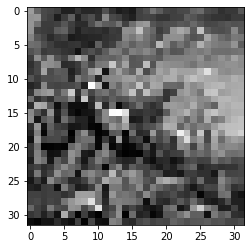

In [153]:
plt.imshow(query.reshape(32,32), cmap='gray')

## Encode the test images and the query image

In [154]:
X_test.shape

(3068, 32, 32, 1)

We remove the query image from the test set (the set in which we will search for close images)

In [155]:
X_test = np.delete(X_test, 7, axis=0)

In [156]:
X_test.shape

(3067, 32, 32, 1)

### Encode the query image and the test set

In [157]:
codes = encoder.predict(X_test)

In [158]:
query_code = encoder.predict(query.reshape(1,32,32,1))

In [159]:
codes.shape

(3067, 4, 4, 8)

In [160]:
query_code.shape

(1, 4, 4, 8)

## Find the closest images

In [161]:
from sklearn.neighbors import NearestNeighbors

We will find the 5 closest images

In [162]:
n_neigh = 5

In [163]:
codes = codes.reshape(-1, 4*4*8); print(codes.shape)
query_code = query_code.reshape(1, 4*4*8); print(query_code.shape)

(3067, 128)
(1, 128)


### Fit the KNN to the test set

In [164]:
nbrs = NearestNeighbors(n_neighbors=n_neigh).fit(codes)

In [165]:
distances, indices = nbrs.kneighbors(np.array(query_code))

In [166]:
closest_images = X_test[indices]

In [167]:
closest_images = closest_images.reshape(-1,32,32,1); print(closest_images.shape)

(5, 32, 32, 1)


## Get the closest images

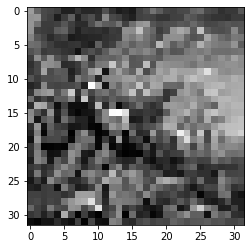

In [168]:
plt.imshow(query.reshape(32,32), cmap='gray')

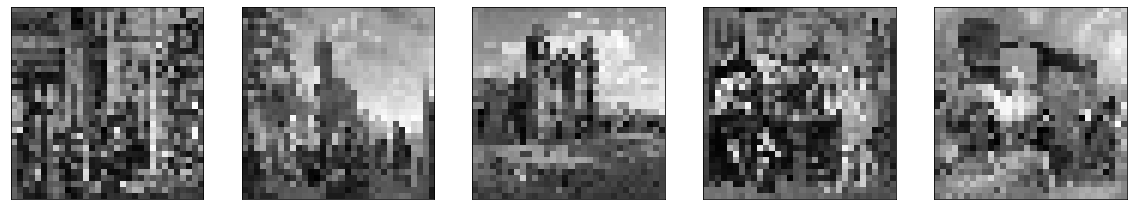

In [169]:
plt.figure(figsize=(20, 6))
for i in range(n_neigh):
    # display original
    ax = plt.subplot(1, n_neigh, i+1)
    plt.imshow(closest_images[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [170]:
final_images = encoder.predict(full)

In [171]:
final_images.shape

(9294, 4, 4, 8)

In [181]:
# use PCA to decrease dimension
df = pd.DataFrame()

In [183]:
# use PCA to decrease dimension
for img in tqdm(image_list):
    filename = img.split('/')[-1]
    img_obj = cv2.imread(img)
    img_obj = cv2.cvtColor(img_obj, cv2.COLOR_BGR2GRAY)
    img_obj = cv2.resize(img_obj, dsize = (32,32))
    img_obj = img_obj.astype('float32') / 1023.
    img_obj = img_obj.reshape(1, 32, 32, 1)
    img_new = np.asarray(encoder.predict(img_obj))
    df = df.append(pd.Series([filename]+img_new.reshape(1,-1)[0].tolist()), ignore_index = True)

In [184]:
df2 = df.copy()
df2 = df2.set_index([0])
df2.to_csv('image_info_cnn.csv')